# Creating a Machine Learning Model to Predict Boston 311 Outcomes


In this notebook we will be exploring the Boston 311 data set and using it to explore principles of Machine Learning.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

%matplotlib inline

The data will be taken from the analyze.boston.gov website, where the 311 request data is published in yearly increments. We will begin our study using the data from 2022:

In [2]:
original_data = pd.read_csv("https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/81a7b022-f8fc-4da5-80e4-b160058ca207/download/tmph4izx_fb.csv",
                            parse_dates=['open_dt', 'target_dt', 'closed_dt'])

In [3]:
original_data.head()

,case_enquiry_id,open_dt,target_dt,closed_dt,ontime,case_status,closure_reason,case_title,subject,reason,...,police_district,neighborhood,neighborhood_services_district,ward,precinct,location_street_name,location_zipcode,latitude,longitude,source
0,101004125189,2022-01-13 12:59:00,2022-01-20 12:59:39,NaT,OVERDUE,Open,,Illegal Rooming House,Inspectional Services,Building,...,C11,Dorchester,8,Ward 17,1706,27 Lithgow St,2124.0,42.2896,-71.0701,Constituent Call
1,101004161747,2022-02-02 11:42:49,2022-02-16 11:42:49,2022-02-02 11:45:47,ONTIME,Closed,Case Closed Case Noted,PublicWorks: Complaint,Mayor's 24 Hour Hotline,Employee & General Comments,...,,,,,,NaN,NaN,42.3594,-71.0587,Constituent Call
2,101004149944,2022-01-28 19:36:00,NaT,NaT,ONTIME,Open,,Space Savers,Public Works Department,Sanitation,...,B3,Greater Mattapan,9,Ward 14,1411,492 Harvard St,2124.0,42.2876,-71.0936,Constituent Call
3,101004113302,2022-01-01 00:36:24,2022-01-04 08:30:00,2022-01-03 00:13:17,ONTIME,Closed,Case Closed. Closed date : 2022-01-03 00:13:17...,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,...,C6,South Boston / South Boston Waterfront,5,6,0601,INTERSECTION Seaport Blvd & Sleeper St,NaN,42.3594,-71.0587,Citizens Connect App
4,101004122704,2022-01-11 09:47:00,2022-02-10 09:47:22,NaT,OVERDUE,Open,,DISPATCHED Heat - Excessive Insufficient,Inspectional Services,Housing,...,B2,Roxbury,13,Ward 12,1202,15 Crawford St,2121.0,42.3110,-71.0841,Constituent Call


There's a lot of different columns, and the data in them is of variable consistentcy and values. We will look at them one by one so we can decide what features to use and how to encode them.

In [4]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276723 entries, 0 to 276722
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   case_enquiry_id                 276723 non-null  int64         
 1   open_dt                         276723 non-null  datetime64[ns]
 2   target_dt                       242593 non-null  datetime64[ns]
 3   closed_dt                       247501 non-null  datetime64[ns]
 4   ontime                          276723 non-null  object        
 5   case_status                     276723 non-null  object        
 6   closure_reason                  276723 non-null  object        
 7   case_title                      276719 non-null  object        
 8   subject                         276723 non-null  object        
 9   reason                          276723 non-null  object        
 10  type                            276723 non-null  object 

## Column Analysis

###case_enquiry_id

The case_enquiry_id column is a numerical id for each case. It has no null values, but it also has no significant predictive power. Probably we shouldn't use it as a feature. we will keep it as a reference column in our clean_data dataframe so we can refer back to our original data later. Let's make sure there are no null values to deal with, and then add the column to our clean_data

In [5]:
print(original_data["case_enquiry_id"].isnull().sum())

0


In [6]:
data = original_data.copy()

###open_dt, closed_dt, and case_status

Here's what chatGPT recommends to do with data like this:

>If you have a minority of cases that are never closed, you can treat them as censored data in your analysis. Censored data refers to observations where you do not have complete information on the outcome of interest. In your case, the cases that are not closed are censored because you do not know how long it will take for them to be closed.
>
>There are different methods to handle censored data in regression analysis. One common method is survival analysis, which is a statistical technique that models the time until an event of interest occurs. In your case, the event of interest is the closing of a case, and the censored data are cases that are not closed.
>
>Survival analysis can handle both right-censored data (where the event of interest has not yet occurred at the end of the study) and left-censored data (where the event of interest has already occurred before the study began). In your case, you have right-censored data because the cases that are not closed have not yet been closed at the end of the study.
>
>You can use a survival analysis technique called Cox proportional hazards regression to model the time until a case is closed while accounting for the censored data. The Cox proportional hazards model estimates the hazard function, which is the probability that a case will be closed at a given time, given that it has not yet been closed. The model can also include predictors, such as the type of case, the location of the case, or the time of the year, to predict how these factors influence the time until a case is closed.
>
>In summary, you can handle the cases that are not closed by treating them as censored data and using a survival analysis technique such as Cox proportional hazards regression to model the time until a case is closed while accounting for the censored data.

In [7]:
data['survival_time'] = data['closed_dt'] - data['open_dt']
data['event'] = data['closed_dt'].notnull().astype(int)

Let's pick a couple columns to look at so we can make a simple model based on just a couple features. Let's evaluate source, subject, reason, and police_district for null values and number of unique categories. 

In [8]:
for column in ["source", "subject", "reason", "police_district"]:
    print(column)
    print(data[column].unique())
    print(data[column].isnull().sum())

source
['Constituent Call' 'Citizens Connect App' 'City Worker App'
 'Self Service' 'Employee Generated']
0
subject
['Inspectional Services' "Mayor's 24 Hour Hotline"
 'Public Works Department' 'Transportation - Traffic Division'
 'Boston Police Department' 'Parks & Recreation Department'
 'Animal Control' 'Boston Water & Sewer Commission' 'Property Management'
 'Neighborhood Services']
0
reason
['Building' 'Employee & General Comments' 'Sanitation'
 'Enforcement & Abandoned Vehicles' 'Housing' 'Generic Noise Disturbance'
 'Street Lights' 'Noise Disturbance' 'Street Cleaning'
 'Highway Maintenance' 'Code Enforcement' 'Park Maintenance & Safety'
 'Animal Issues' 'Environmental Services' 'Signs & Signals' 'Catchbasin'
 'Needle Program' 'Traffic Management & Engineering' 'Health'
 'Weights and Measures' 'Trees' 'Recycling'
 'Administrative & General Requests' 'Abandoned Bicycle' 'Graffiti'
 'Sidewalk Cover / Manhole' 'Notification' 'Neighborhood Services Issues'
 'Air Pollution Control' '

Source, subject, and reason have limited values, and no nulls. Police district is messier. We could just drop the 122 null values, but how many have a blank value? The code below tells us it's 2511

In [9]:
data["police_district"].value_counts()

D4     43531
A1     33562
C6     29273
C11    28931
B2     25353
D14    21476
A7     19151
E5     16880
E13    16648
B3     16468
E18    13401
A15     9416
        2511
Name: police_district, dtype: int64

Let's generate graphs for all of the columns with no nulls and fewer than 100 unique values.

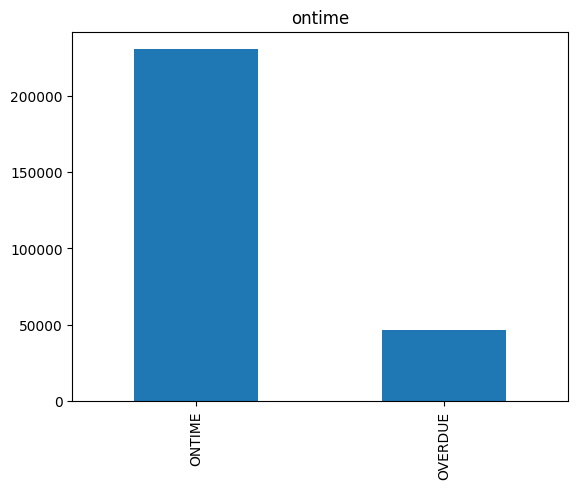

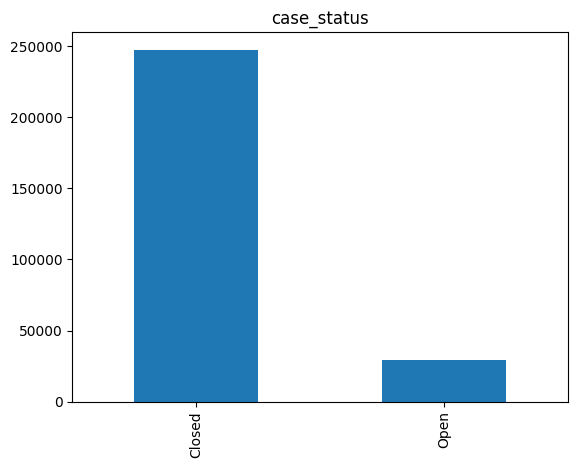

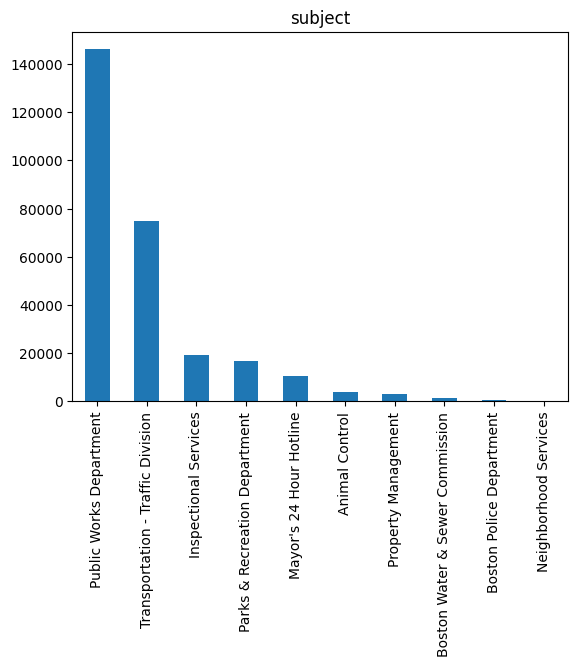

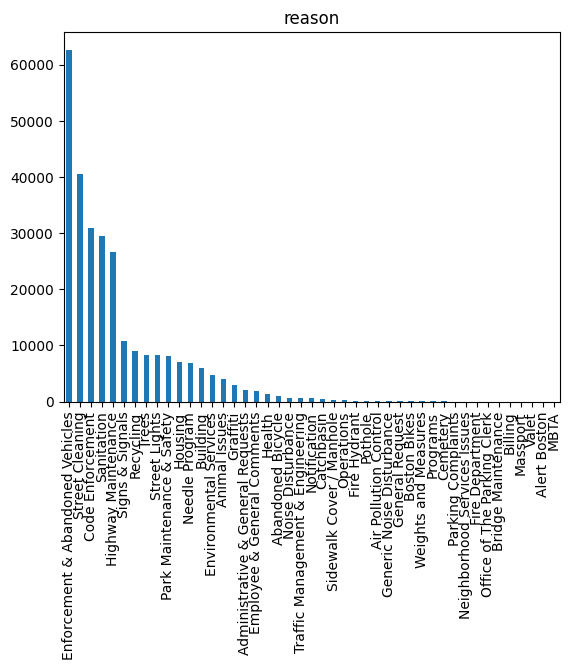

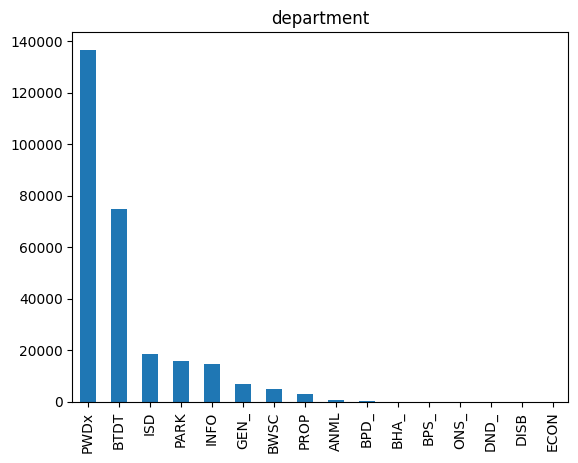

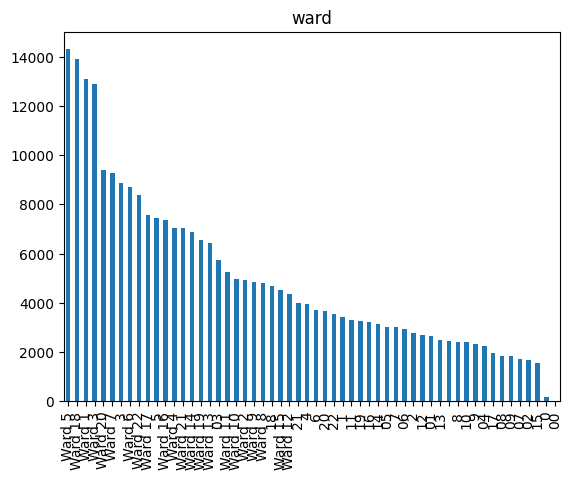

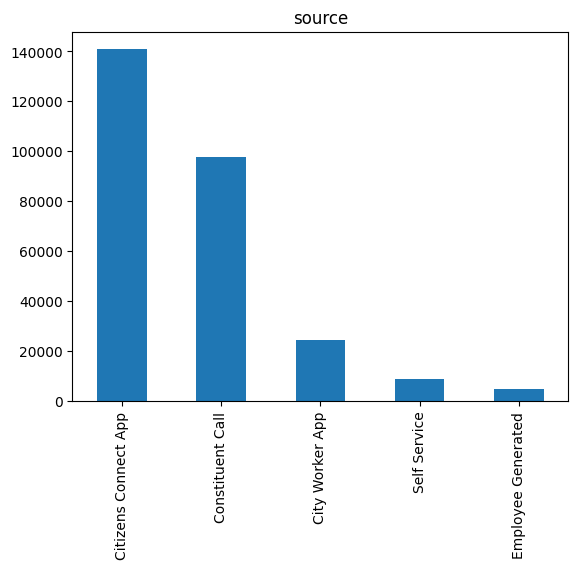

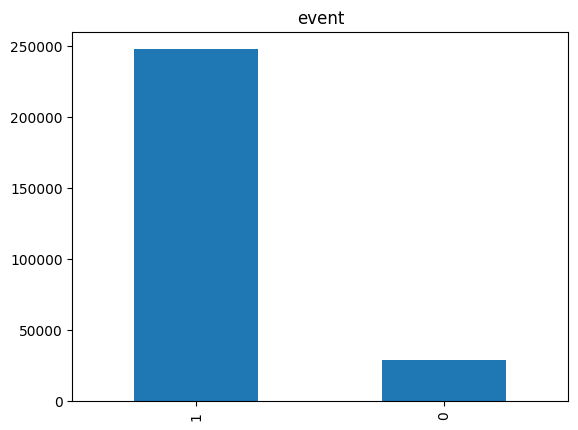

In [10]:
# loop through each column in the dataframe
for column in data.columns:
    # check if the column has no missing values and fewer than 40 unique values
  if len(data[column].unique()) < 100 :
    if data[column].isnull().sum() == 0:
        # plot a bar chart of the count of each unique value in the column
        data[column].value_counts().plot(kind="bar")
        plt.title(column)
        plt.show()


Looking at these charts, subject, reason, department, source and ward are good options, but ward needs to be normalized to contain just the number.

<Axes: >

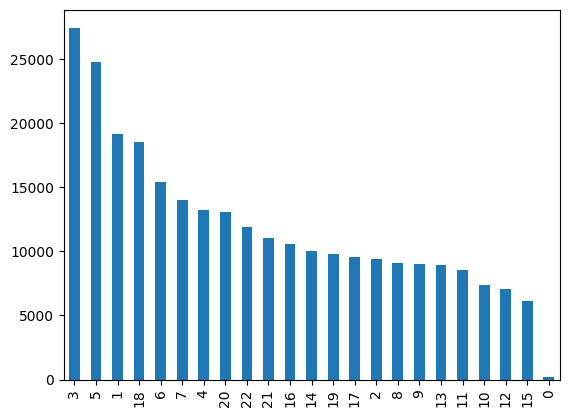

In [11]:
data['ward_number'] = data['ward'].str.extract(r'0*(\d+)')
data['ward_number'].value_counts().plot(kind="bar")

So now we have subject, reason, department, source and ward_number as our categorical features. and our labels are survival_time and event

##One Hot Encoding our Categories for Logistic Regression

Now that we have cleaned out data and determines our labels and first ML algorithm, let's encode our categorical features as one hot encoded feature columns

In [12]:
cols_to_keep = ['case_enquiry_id', 'survival_time', 'event', 'subject', 'reason', 'department', 'source', 'ward_number']
clean_data = data[cols_to_keep].copy()
#clean_data['survival_time_minutes'] = clean_data['survival_time'].apply(lambda x: x.total_seconds()/3600)
clean_data = pd.get_dummies(clean_data, columns=['subject', 'reason', 'department', 'source', 'ward_number'])

##Training a Logistic Regression Model to predict if a case will eventually be closed


In [13]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Load data

# Split into features and target
X = clean_data.drop(['event', 'survival_time'], axis=1)
y = clean_data['event']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build model
model = keras.Sequential([
    keras.layers.Dense(units=1, input_shape=(X_train.shape[1],), activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=4, batch_size=32)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)



Epoch 1/4
6919/6919 [==============================] - 13s 2ms/step - loss: 238053680.0000 - accuracy: 0.7926
Epoch 2/4
6919/6919 [==============================] - 12s 2ms/step - loss: 5375400.0000 - accuracy: 0.8118
Epoch 3/4
6919/6919 [==============================] - 12s 2ms/step - loss: 5028443.0000 - accuracy: 0.8119
Epoch 4/4
1730/1730 [==============================] - 3s 1ms/step - loss: 10096745.0000 - accuracy: 0.8936
Test accuracy: 0.8935585618019104


##Testing Our Logistic Regression Model on 2023 data

In [14]:
data_2023 = pd.read_csv("https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/e6013a93-1321-4f2a-bf91-8d8a02f1e62f/download/tmp9g_820k8.csv",
                            parse_dates=['open_dt', 'target_dt', 'closed_dt'])

In [15]:
data_2023['survival_time'] = data_2023['closed_dt'] - data_2023['open_dt']
data_2023['event'] = data_2023['closed_dt'].notnull().astype(int)
data_2023['ward_number'] = data_2023['ward'].str.extract(r'0*(\d+)')
clean_data_2023 = data_2023[cols_to_keep].copy()
clean_data_2023 = pd.get_dummies(clean_data_2023, columns=['subject', 'reason', 'department', 'source', 'ward_number'])

In [28]:
#add missing features to 2023 data:


missing_features = list(set(clean_data.columns.tolist())-set(clean_data_2023.columns.tolist()))
print(missing_features)

clean_data_2023[missing_features] = 0

['department_ECON', 'reason_Billing', 'reason_Fire Department', 'reason_General Request']


In [32]:
#some features are present in 2023 that are missing from 2022
list(set(clean_data_2023.columns.tolist())-set(clean_data.columns.tolist()))

['department_GRNi', 'department_No Q', 'source_Maximo Integration']

In [29]:
# Extract the predictor variables from the preprocessed 2023 data
X_2023 = clean_data_2023.drop(['event', 'survival_time'], axis=1)

# Extract the actual 2023 values
y_actual_2023 = clean_data_2023['event'].values

In [30]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(model, X_test, y_test):
    # Use the model to predict the test set
    y_pred = model.predict(X_test)
    
    # Convert the predicted probabilities to binary predictions
    y_pred_binary = np.round(y_pred)
    
    # Calculate the evaluation metrics
    accuracy = accuracy_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    
    # Print the evaluation metrics
    print("Accuracy: {:.2f}".format(accuracy))
    print("F1 Score: {:.2f}".format(f1))
    
    # Return the evaluation metrics
    return accuracy, f1

accuracy, f1 = evaluate_model(model, X_2023, y_actual_2023)

ValueError: ignored

##Training a Linear Regression Model to predict survival_time

In [34]:
clean_data_survival_mask = clean_data["survival_time"].notnull()
clean_data_survival = clean_data[clean_data_survival_mask].copy()
clean_data_survival['survival_time_hours'] = clean_data_survival['survival_time'].apply(lambda x: x.total_seconds()/3600)

clean_data_2023_survival_mask = clean_data["survival_time"].notnull()
clean_data_2023_survival = clean_data[clean_data_2023_survival_mask].copy()
clean_data_2023_survival['survival_time_hours'] = clean_data_2023_survival['survival_time'].apply(lambda x: x.total_seconds()/3600)

In [35]:
clean_data_2023_survival["survival_time_hours"].describe()

count    247501.000000
mean        132.223485
std         502.381809
min           0.000833
25%           1.604167
50%          12.028333
75%          50.717222
max        8633.708333
Name: survival_time_hours, dtype: float64

In [36]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# load and preprocess data

X = clean_data_survival.drop(['survival_time_hours', 'survival_time', 'event'], axis=1) # drop the target and event columns
y = clean_data_survival['survival_time_hours']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # scale the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# define the model architecture
model_survival = keras.Sequential([
    keras.layers.Dense(units=1, input_dim=X_train.shape[1])
])

# compile the model
model_survival.compile(optimizer='adam', loss='mean_squared_error')

# train the model
model_survival.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)





Epoch 1/50
6188/6188 [==============================] - 11s 2ms/step - loss: 267240.0938
Epoch 2/50
6188/6188 [==============================] - 10s 2ms/step - loss: 259876.4531
Epoch 3/50
6188/6188 [==============================] - 11s 2ms/step - loss: 253358.5781
Epoch 4/50
6188/6188 [==============================] - 10s 2ms/step - loss: 247653.8281
Epoch 5/50
6188/6188 [==============================] - 11s 2ms/step - loss: 242538.5938
Epoch 6/50
6188/6188 [==============================] - 10s 2ms/step - loss: 237962.6406
Epoch 7/50
6188/6188 [==============================] - 10s 2ms/step - loss: 233876.2969
Epoch 8/50
6188/6188 [==============================] - 10s 2ms/step - loss: 230182.6562
Epoch 9/50
6188/6188 [==============================] - 10s 2ms/step - loss: 226827.7969
Epoch 10/50
6188/6188 [==============================] - 12s 2ms/step - loss: 223790.9219
Epoch 11/50
6188/6188 [==============================] - 11s 2ms/step - loss: 221078.3750
Epoch 12/50
6188/61

In [37]:
# Extract the predictor variables from the preprocessed 2023 data
X_2023_survival = clean_data_2023_survival.drop(['event', 'survival_time', 'survival_time_hours'], axis=1)

# Extract the actual 2023 values
y_actual_2023_survival = clean_data_2023_survival['survival_time_hours'].values

In [38]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


def evaluate_model_survival(model, X_test, y_test):
    # Make predictions on test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Print evaluation metrics
    print("Mean squared error: {:.2f}".format(mse))
    print("R-squared score: {:.2f}".format(r2))
    print("Mean absolute error: {:.2f}".format(mae))

evaluate_model_survival(model_survival, X_2023_survival, y_actual_2023_survival)

7735/7735 [==============================] - 13s 2ms/step
Mean squared error: 18318531082043878044336128.00
R-squared score: -72581274437422161920.00
Mean absolute error: 4280015313291.17


We have created two models, a logistic model, and a linear regression model.
Here are some possible to-dos:

1. Train the models on all the historical 311 data
2. Add more features
3. clean up the data by removing outliers
4. deal with the missing feature columns between 2022 and 2023 data because some categorical feature values are missing from one or the other, resulting in one hot encoded column mismatches.
5. Develop some heuristics to see if our Machine Learning model can actually do better than some obvious correlations.

Questions to answer:
1. Can we find some basic commonality between open cases?
2. When and how is the target date set? How about the overdue flag?
3. Do cases autoclose after a certain time?
4. Do cases carry over from year to year? If so, do they keep the same case_enquiry_id? (probably they do, but it would be good to confirm)